Import Necessary Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Load and Preprocess Dataset

In [3]:
# Load the dataset
train = pd.read_parquet("/kaggle/input/d/shuvookd/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/d/shuvookd/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

# Convert categorical columns to numerical
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

# Separate features and target variable
X = df.drop('label', axis=1)
y = df['label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create DataFrame from scaled data
X = pd.DataFrame(X_scaled, columns=X.columns)

Define SimCLR Components (Encoder, Contrastive Loss, Augmentation)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build the encoder model (simple fully connected layers for simplicity)
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)  # Projection head
    return models.Model(inputs, projection)

# Contrastive loss function (NT-Xent loss)
def contrastive_loss(query, key, temperature=0.07):
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)
    similarity = tf.matmul(query, key, transpose_b=True)
    similarity /= temperature
    labels = tf.zeros(similarity.shape[0], dtype=tf.int32)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=similarity)
    return tf.reduce_mean(loss)

# Augmentation function (add random noise)
def augment_batch(X):
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise

Train and Evaluate for Different Train-Test Splits

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np


# Train-test split ratios
ratios = [(10,90), (20,80), (30,70), (40,60), (50,50), (60,40), (70,30), (80,20), (90,10)]
all_results = []

# Loop over different train-test splits
for train_pct, test_pct in ratios:
    print(f"\n--- Train:Test = {train_pct}:{test_pct} ---")

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct/100,
        stratify=y,
        random_state=42
    )

    # Initialize encoders
    query_encoder = build_encoder(X_train.shape[1])
    key_encoder = build_encoder(X_train.shape[1])

    # Initialize optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    
    epochs = 20
    batch_size = 512
    num_samples = X_train.shape[0]

    # Training loop
    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]
        y_shuffled = y_train[idx]

        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i+batch_size]
            if batch.shape[0] < 2:
                continue

            # Augment the batch for query and key
            x_q = augment_batch(batch)
            x_k = augment_batch(batch)

            with tf.GradientTape() as tape:
                z_q = query_encoder(x_q, training=True)
                z_k = key_encoder(x_k, training=True)
                loss = contrastive_loss(z_q, z_k)

            grads = tape.gradient(loss, query_encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, query_encoder.trainable_variables))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")

    # Evaluate with Random Forest Classifier
    X_train_ssl = query_encoder.predict(X_train)
    X_test_ssl = query_encoder.predict(X_test)

    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf.fit(X_train_ssl, y_train)
    y_pred = rf.predict(X_test_ssl)
    report = classification_report(y_test, y_pred, output_dict=True)

    acc = report['accuracy']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']

    # Store the results for each split and epoch
    all_results.append({
        'train_pct': train_pct,
        'test_pct': test_pct,
        'epoch': epoch + 1,
        'accuracy': acc,
        'f1_class_0': f1_0,
        'f1_class_1': f1_1
    })

    print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")


# Convert the results to a DataFrame and save to CSV
results_df = pd.DataFrame(all_results)
results_df.to_csv('simclr_ssl_rf_results_all_epochs.csv', index=False)
print("\nSaved results to 'simclr_ssl_rf_results_all_epochs.csv'")


--- Train:Test = 10:90 ---


I0000 00:00:1750419638.767964      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750419638.768629      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20, Loss: 5.5966
Epoch 2/20, Loss: 5.3825
Epoch 3/20, Loss: 5.4160
Epoch 4/20, Loss: 5.1170
Epoch 5/20, Loss: 5.7059
Epoch 6/20, Loss: 5.0597
Epoch 7/20, Loss: 5.7837
Epoch 8/20, Loss: 5.1807
Epoch 9/20, Loss: 4.9386
Epoch 10/20, Loss: 5.4854
Epoch 11/20, Loss: 4.9144
Epoch 12/20, Loss: 4.8071
Epoch 13/20, Loss: 5.2194
Epoch 14/20, Loss: 5.1808
Epoch 15/20, Loss: 4.9666
Epoch 16/20, Loss: 5.3399
Epoch 17/20, Loss: 5.2518
Epoch 18/20, Loss: 5.3419
Epoch 19/20, Loss: 5.1203
Epoch 20/20, Loss: 5.2349


I0000 00:00:1750419694.473703      90 service.cc:148] XLA service 0x7f42bc031230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750419694.474371      90 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750419694.474392      90 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750419694.549199      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


130/806 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1750419694.825253      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8988, F1 Class 0: 0.8541, F1 Class 1: 0.9226

--- Train:Test = 20:80 ---
Epoch 1/20, Loss: 6.0851
Epoch 2/20, Loss: 5.7136
Epoch 3/20, Loss: 6.3917
Epoch 4/20, Loss: 5.6602
Epoch 5/20, Loss: 6.0745
Epoch 6/20, Loss: 6.0197
Epoch 7/20, Loss: 5.7229
Epoch 8/20, Loss: 5.7453
Epoch 9/20, Loss: 5.8046
Epoch 10/20, Loss: 6.0250
Epoch 11/20, Loss: 6.2057
Epoch 12/20, Loss: 5.6872
Epoch 13/20, Loss: 5.7583
Epoch 14/20, Loss: 5.8845
Epoch 15/20, Loss: 5.9070
Epoch 16/20, Loss: 5.7344
Epoch 17/20, Loss: 6.0358
Epoch 18/20, Loss: 5.8265
Epoch 19/20, Loss: 5.7932
Epoch 20/20, Loss: 5.7299
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Accuracy: 0.9011, F1 Class 0: 0.8580, F1 Class 1: 0.9241

--- Train:Test = 30:70 ---
Epoch 1/20, Loss: 6.2308
Epoch 2/20, Loss: 6.0795
Epoch 3/20, Loss: 6.1202
Epoch 4/20, Loss: 5.7698
Epoch 5/20, Loss: 6.1676
Epoch 6/20, Loss: 6.0883

 Visualize the Results

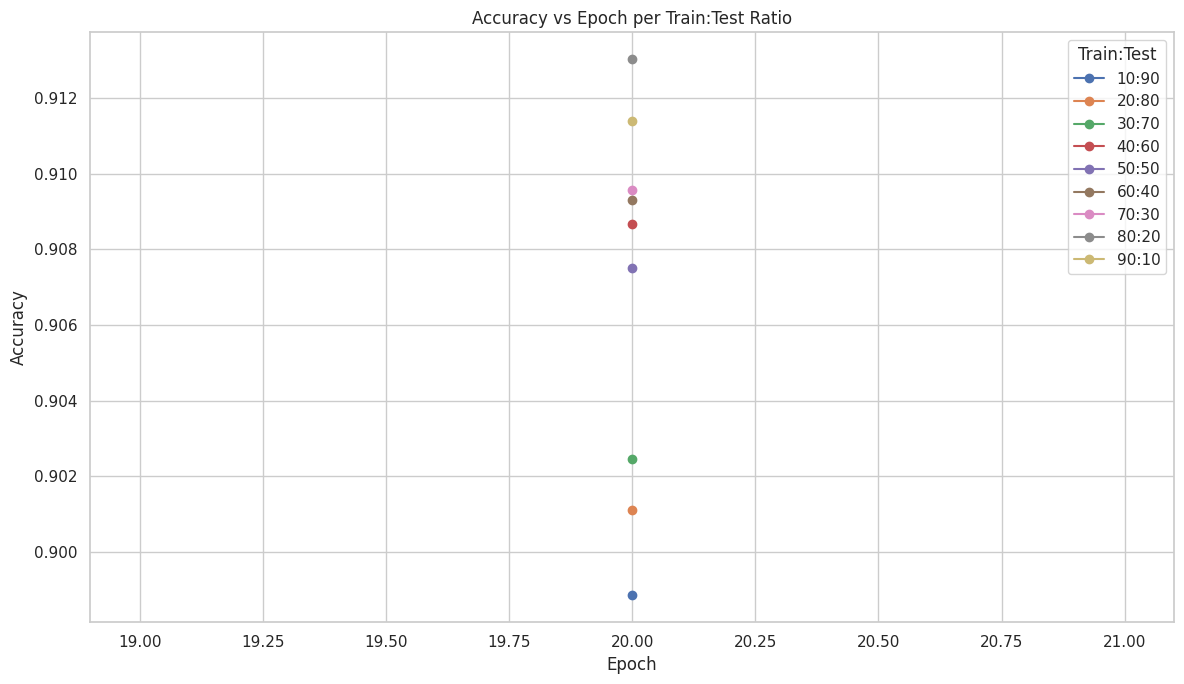

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Extract unique train-test ratio combinations
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Accuracy vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of Loss vs Epoch per Train:Test Split
sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Loss vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['loss'], marker='o', label=label)

plt.title("Contrastive Loss vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()


KeyError: 'loss'

<Figure size 1200x700 with 0 Axes>

/tmp/ipykernel_35/2560087156.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="train_pct", y="accuracy", hue="test_pct", data=final_results, ci=None)


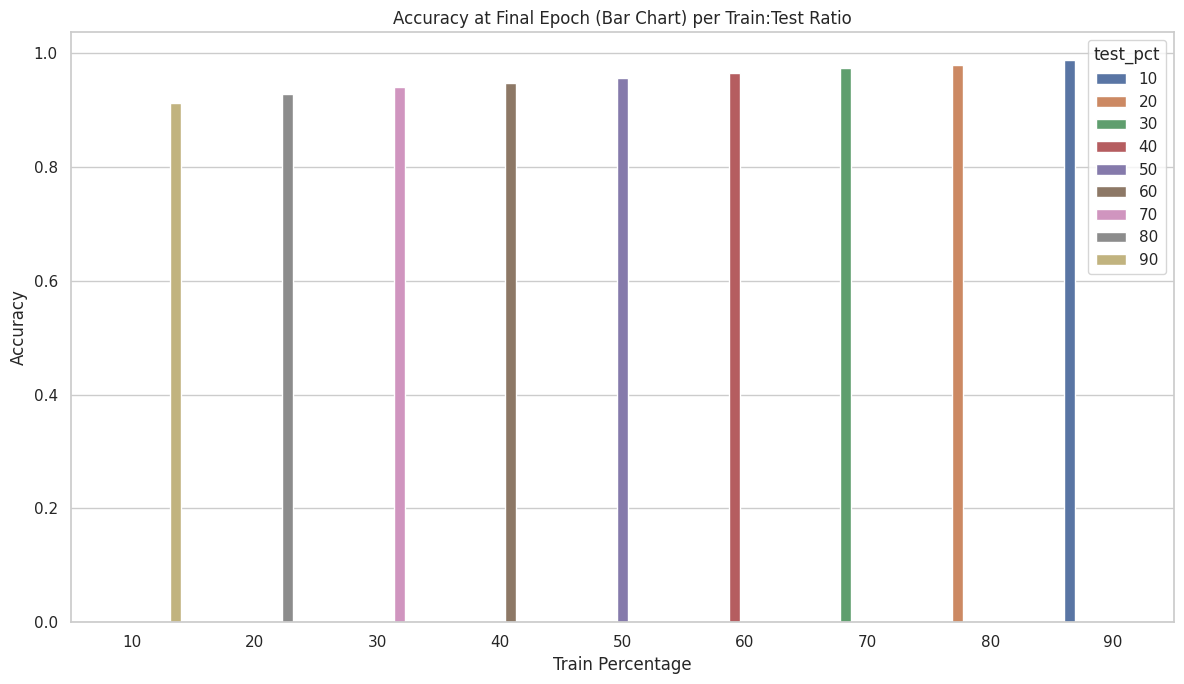

/tmp/ipykernel_35/2560087156.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="train_pct", y="loss", hue="test_pct", data=final_results, ci=None)


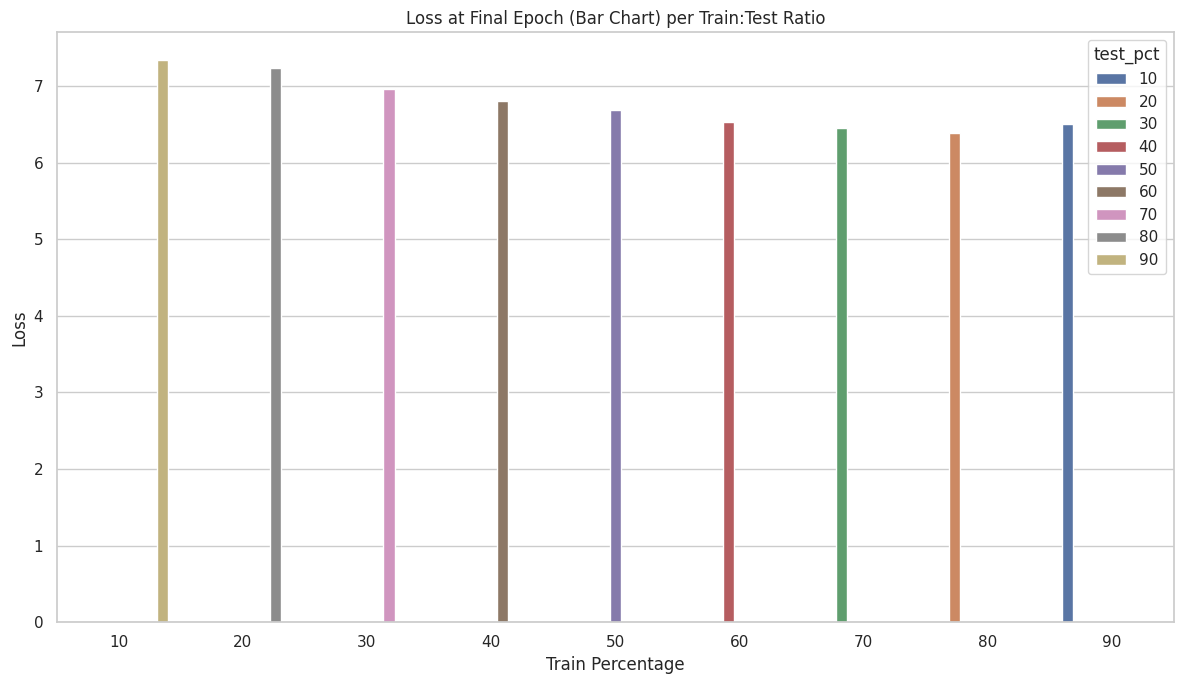

In [11]:
# Filter results for the final epoch (assuming 20 epochs)
final_results = results_df[results_df['epoch'] == 20]

# Accuracy Bar Chart
plt.figure(figsize=(12, 7))
sns.barplot(x="train_pct", y="accuracy", hue="test_pct", data=final_results, ci=None)
plt.title("Accuracy at Final Epoch (Bar Chart) per Train:Test Ratio for SimCLR")
plt.xlabel("Train Percentage")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Loss Bar Chart
plt.figure(figsize=(12, 7))
sns.barplot(x="train_pct", y="loss", hue="test_pct", data=final_results, ci=None)
plt.title("Loss at Final Epoch (Bar Chart) per Train:Test Ratio for SimCLR")
plt.xlabel("Train Percentage")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()
